<a href="https://colab.research.google.com/github/dattali18/IR_Assignments/blob/main/Assignment.02/notebooks/IR_02_Clustering_Doc2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

## 1. Objective

Take the document (meaning vector representation of the document, the ouput of the last assginment `Doc2Vec`, `BERT`, `Sentence-BERT`, times 4 group from each) and cluster them into groups and compare the results with the actuale division form each publication.

## 2. Input

4 Groups of matrices each line repesent a document in it's vector form, from:

1. `Doc2Vec`
2. `BERT`
3. `Sentence-BERT`

### 3. Task

  - Combine the four matrices into a single matrix for each technique.
  - Apply clustering using:
    - **K-Means** (with `k=4` for 4 journals).
    - **DBSCAN** (select `eps` and `min_samples` heuristically).
    - **Gaussian Mixture Model**.
  - Evaluate the clusters using:
    - Metrics: Precision, Recall, F1-Score, Accuracy.
    - Visualization: Use UMAP, t-SNE, or other tools (e.g., Seaborn).


### 4. Output

- The plot of the real clusters vs. the clusters from the 3 methods mentioned above.
- The metrics for each clustering method.

# Doc2Vec Matrices

We have 4 `.csv` files with each $(100, \approx 600)$ and we need to combine them into one big matrix and then cluster them.

## Plan

1. Download the files from my `GitHub`.
2. Add a `'cluster'` column for each file (`=0` for AJ etc...).
3. Cluster with `Kmeans` for `k=4`.
4. Write a function to find the right parameters for 4 clusters for `DBSCAN` (i.e. the `eps` and `min_samples` parameters).
5. Cluster with `DBSCAN`
6. Cluster with `GMM`
7. Use `t-SNE` to visualize the cluster in $\mathbb{R}^2$
8. Output the plot for each clustering methods + original
9. Measure each method using the metric mentioned above.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Download the files from my `GitHub`

In [2]:
doc2vec_link = "https://github.com/dattali18/IR_Assignments/blob/main/Assignment.02/data/doc2vec/doc2vec_vectors.csv?raw=true"

In [3]:
import pandas as pd

# download the data using the link
df_original = pd.read_csv(doc2vec_link)
df_original.head()

,Sheet,RowIndex,Dim0,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,...,Dim290,Dim291,Dim292,Dim293,Dim294,Dim295,Dim296,Dim297,Dim298,Dim299
0,A-J,0,-0.323680,0.536064,-0.057541,-0.086456,-0.131206,-0.565315,0.091184,0.368373,...,-0.037265,0.056639,0.215756,-0.263049,-0.204844,0.068097,0.245854,-0.162075,0.073809,0.537919
1,A-J,1,-0.145474,0.580617,0.055538,-0.136570,-0.058198,-0.529168,0.381029,0.835640,...,-0.481531,0.365477,-0.074856,-0.033853,-0.164452,-0.202104,-0.103379,0.000104,-0.368583,-0.151190
2,A-J,2,-0.152601,0.434339,0.476579,0.219742,0.206865,-0.808800,0.463602,0.788595,...,0.038521,0.135275,0.485610,0.053291,-0.023656,-0.419926,0.609322,-0.238771,0.237107,-0.047717
3,A-J,3,-0.612203,0.287306,0.622638,0.347806,0.310982,-0.528447,0.356173,0.113392,...,-0.246450,0.215634,0.300776,-0.041372,0.184252,0.054860,0.735316,-0.073491,0.210143,-0.134298
4,A-J,4,-0.418779,0.231471,0.634521,0.376488,0.096662,-0.396122,0.530038,0.292624,...,-0.199178,0.173679,0.205028,0.295934,0.149091,0.267297,0.484595,-0.314126,0.394436,-0.279832


In [37]:
df_original.shape

(2346, 302)

In [4]:
# create a new df where whe have the following column
# 1. Sheet with the name 'A-J', 'BBC', 'J-P', 'NY-T'
# 2. vector the numpy vector represntation (get all the value from Dim0 - Dim299 and make a list from them)

df = pd.DataFrame()

df['Sheet'] = df_original['Sheet']

df['vector'] = df_original.iloc[:, 2:].values.tolist()

df.head()

,Sheet,vector
0,A-J,"[-0.323680430650711, 0.5360641479492188, -0.05..."
1,A-J,"[-0.1454735696315765, 0.5806173086166382, 0.05..."
2,A-J,"[-0.1526012271642685, 0.4343386590480804, 0.47..."
3,A-J,"[-0.6122026443481445, 0.287306398153305, 0.622..."
4,A-J,"[-0.4187790155410766, 0.2314711958169937, 0.63..."


In [5]:
# standerdize the data mean=0 std=1

from sklearn.preprocessing import StandardScaler
import numpy as np


scaler = StandardScaler()

# apply to each line of the df

df['std_vector'] = df['vector'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
df['std_vector'].head()

,std_vector
0,"[-0.8898444679243975, 1.5867284496581213, -0.1..."
1,"[-0.45412855563660753, 1.5962898513829487, 0.1..."
2,"[-0.4265908635369363, 1.2374741265373976, 1.35..."
3,"[-1.7774307627408343, 0.8400083803083657, 1.81..."
4,"[-1.315865498091188, 0.6433641277978894, 1.857..."


In [6]:
cluster_map = {'A-J': 0, 'BBC': 1, 'J-P': 2, 'NY-T': 3}
df['cluster'] = df['Sheet'].map(cluster_map)

In [7]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [8]:
# visualize the real cluster using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

# transofrm the df['vector'] to dataframe with freatuer 0 - 299 for
df_copy = df['std_vector'].apply(pd.Series)

df_tsne = tsne.fit_transform(df_copy)

df_tsne = pd.DataFrame(df_tsne, columns=['x', 'y'])

df_tsne['cluster'] = df['cluster']

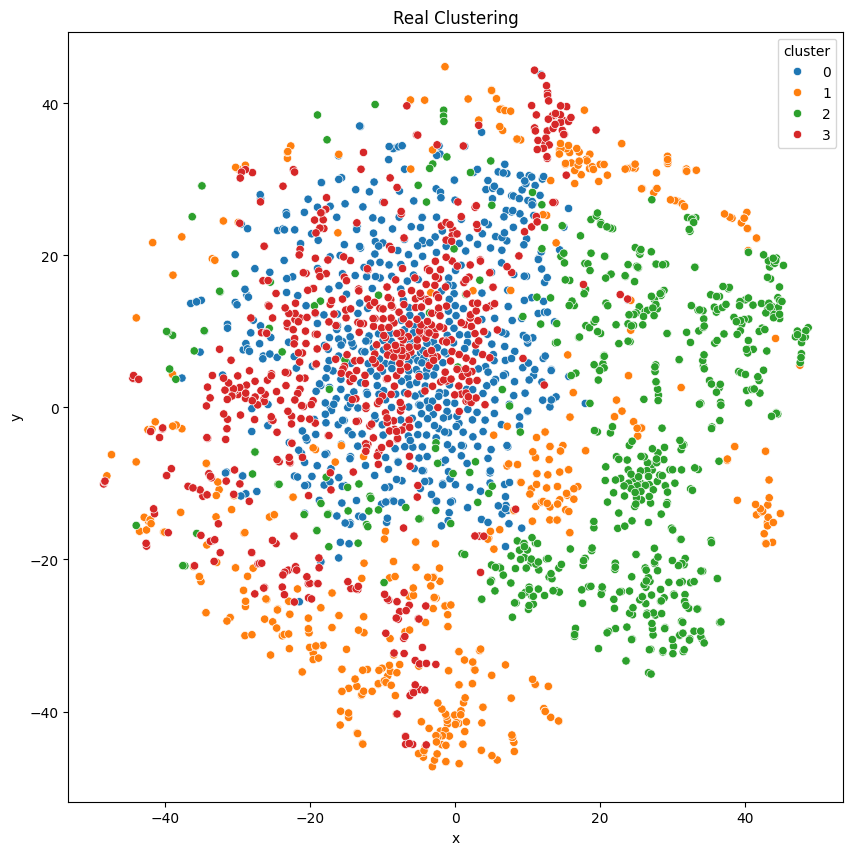

In [9]:
# plot the df_tsne
df_tsne['cluster'] = df_tsne['cluster'].map(str)

plt.figure(figsize=(10, 10))
# add labels
plt.title('Real Clustering')

# make color scheme red, blue, green etc
sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster')

plt.show()

### Kmeans

In [10]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df['std_vector'].tolist())

df['cluster_kmeans'] = kmeans.labels_

df['cluster_kmeans'].head()

,cluster_kmeans
0,3
1,3
2,3
3,3
4,3


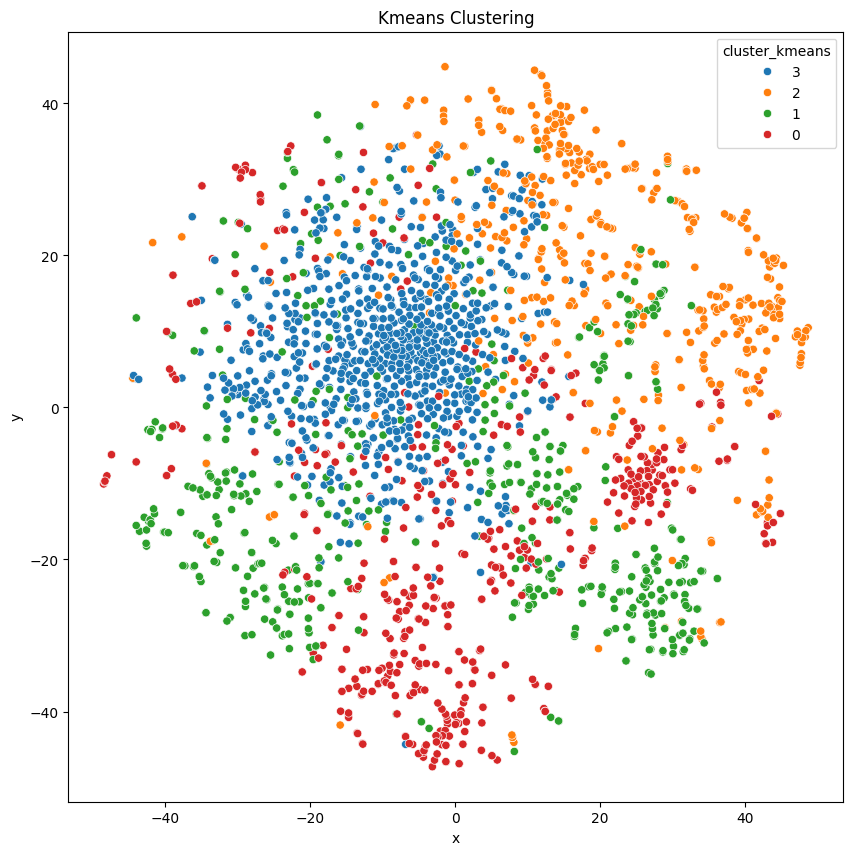

In [13]:
# visutalize the cluster using the t-SNE df

df_tsne['cluster_kmeans'] = df['cluster_kmeans']
df_tsne['cluster_kmeans'] = df_tsne['cluster_kmeans'].map(str)

plt.figure(figsize=(10, 10))

plt.title('Kmeans Clustering')

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_kmeans')

plt.show()

### DBSCAN

In [31]:
!pip install kneed

In [32]:
# import numpy as np
# import pandas as pd
# from sklearn.neighbors import NearestNeighbors
# from kneed import KneeLocator
# from sklearn.cluster import DBSCAN

# def get_parameters(df, num_clusters=4, eps_adjustment=1.0, min_samples_adjustment=1):
#     X = np.array(df)

#     # Use NearestNeighbors to find the nearest neighbors
#     neighbors = NearestNeighbors(n_neighbors=2 * X.shape[1] - 1, metric="cosine")
#     neighbors_fit = neighbors.fit(X)
#     distances, indices = neighbors_fit.kneighbors(X)
#     distances = np.sort(distances, axis=0)
#     distances = distances[:, 1]

#     # Use KneeLocator to find the "elbow" point in the k-distance graph
#     kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
#     eps = distances[kneedle.elbow] * eps_adjustment

#     # Set min_samples to 2 * dimensions, another common heuristic
#     min_samples = 2 * X.shape[1] * min_samples_adjustment

#     return eps, min_samples

# def find_best_parameters(df, num_clusters=4):
#     best_eps = None
#     best_min_samples = None
#     best_num_clusters = 0

#     for eps_adjustment in np.arange(0.5, 2.0, 0.1):
#         for min_samples_adjustment in range(1, 5):
#             eps, min_samples = get_parameters(df, num_clusters, eps_adjustment, min_samples_adjustment)
#             db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
#             labels = db.labels_
#             num_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)

#             if num_clusters_found == num_clusters:
#                 return eps, min_samples

#             if num_clusters_found > best_num_clusters:
#                 best_eps = eps
#                 best_min_samples = min_samples
#                 best_num_clusters = num_clusters_found

#     return best_eps, best_min_samples

# eps, min_samples = find_best_parameters(df['std_vector'].tolist(), num_clusters=4)
# print(f"Best eps: {eps}, Best min_samples: {min_samples}")

Best eps: None, Best min_samples: None


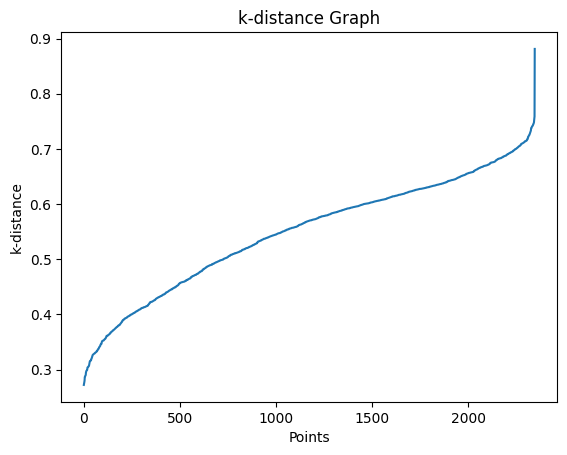

In [42]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 301 - 1
nn_model = NearestNeighbors(n_neighbors=k, metric="cosine")
nn_model.fit(df['std_vector'].tolist())
distances, _ = nn_model.kneighbors(df['std_vector'].tolist())

k_distances = np.sort(distances[:, -1])
plt.plot(k_distances)
plt.xlabel('Points')
plt.ylabel('k-distance')
plt.title('k-distance Graph')
plt.show()

In [50]:
# use DBSCAN

dbscan = DBSCAN(eps=0.35, min_samples=301, metric="cosine").fit(df['std_vector'].tolist())

df['cluster_dbscan'] = dbscan.labels_

# count the number of cluster

num_clusters = len(df['cluster_dbscan'].unique())

print(f"Number of clusters: {num_clusters}")

Number of clusters: 2


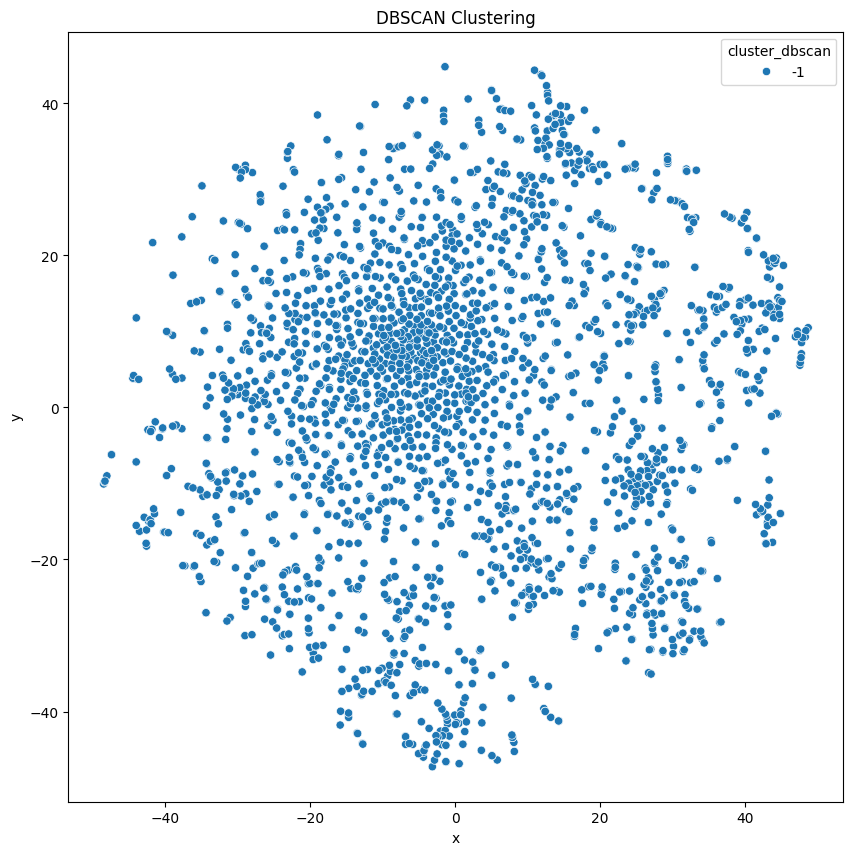

In [33]:
# visualize data

# visutalize the cluster using the t-SNE df

df_tsne['cluster_dbscan'] = df['cluster_dbscan']

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('DBSCAN Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_dbscan'] = df_tsne['cluster_dbscan'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_dbscan')

plt.show()

### GMM

In [ ]:
# apply GMM

gmm = GaussianMixture(n_components=4, random_state=0).fit(df['std_vector'].tolist())

df['cluster_gmm'] = gmm.predict(df['std_vector'].tolist())

df['cluster_gmm'].head()


,cluster_gmm
0,3
1,3
2,3
3,3
4,3


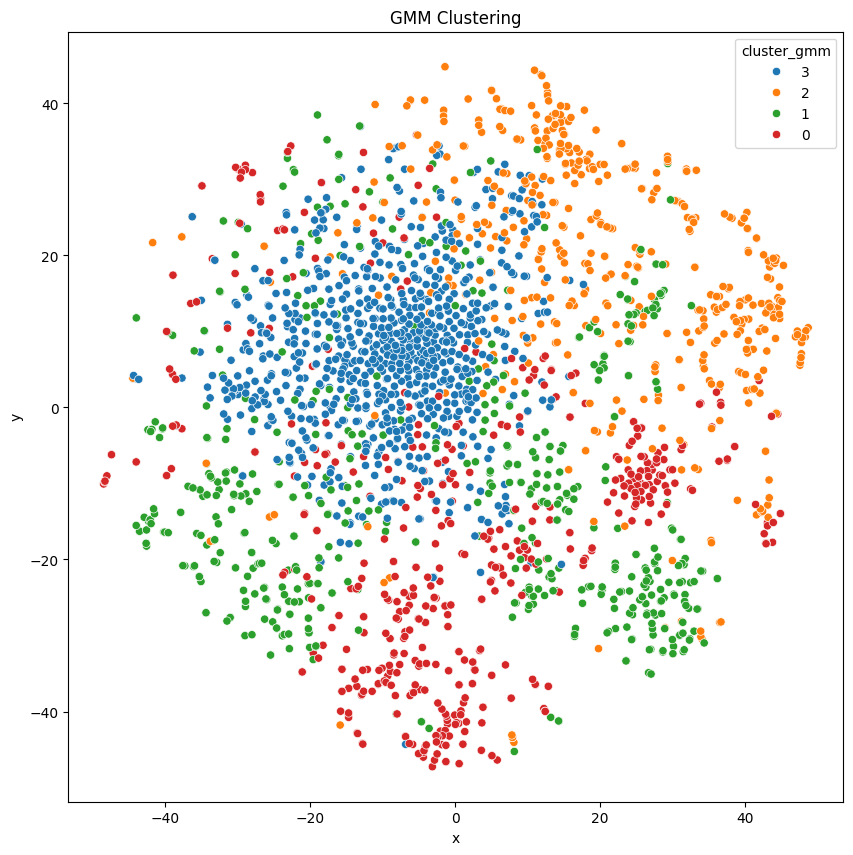

In [ ]:
# visualize data

# visutalize the cluster using the t-SNE df

df_tsne['cluster_gmm'] = df['cluster_gmm']

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('GMM Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_gmm'] = df_tsne['cluster_gmm'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_gmm')

plt.show()

## Measurements

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evluate_model(real, pred):
    precision = precision_score(real, pred, average='macro')
    recall = recall_score(real, pred, average='macro')
    f1 = f1_score(real, pred, average='macro')
    accuracy = accuracy_score(real, pred)

    return precision, recall, f1, accuracy

In [ ]:
kmeans_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

kmeans_evalutation_df.loc['kmeans'] = evluate_model(df['cluster'], df['cluster_kmeans'])

kmeans_evalutation_df

,precision,recall,f1,accuracy
kmeans,0.355405,0.369908,0.359152,0.37127


In [ ]:
# same for DBSCAN but map -1 to 2
df['cluster_dbscan'] = df['cluster_dbscan'].map(lambda x: x if x != -1 else 2)

dbscan_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

dbscan_evalutation_df.loc['dbscan'] = evluate_model(df['cluster'], df['cluster_dbscan'])

dbscan_evalutation_df

,precision,recall,f1,accuracy
dbscan,0.229082,0.446578,0.302396,0.456095


In [ ]:
# same for GMM

gmm_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

gmm_evalutation_df.loc['gmm'] = evluate_model(df['cluster'], df['cluster_gmm'])

gmm_evalutation_df

,precision,recall,f1,accuracy
gmm,0.355141,0.36987,0.358822,0.37127
